In [1]:
import cv2

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
class ImagePreprocessor:
    """Handles all preprocessing steps for blocks world images"""
    
    def __init__(self, edge_threshold=30, vertical_tolerance=15):
        self.edge_threshold = edge_threshold
        self.vertical_tolerance = vertical_tolerance
    
    def preprocess_image(self, img):
        """
        Convert image to binary and extract edges with gradients
        """
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Otsu thresholding for binary segmentation
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Invert so objects are white, background is black
        binary = 255 - binary
        
        # Compute image gradients using Sobel operators
        gx = cv2.Sobel(gray.astype(float), cv2.CV_64F, 1, 0, ksize=3)
        gy = cv2.Sobel(gray.astype(float), cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate edge strength (gradient magnitude)
        edge_strength = np.sqrt(gx**2 + gy**2)
        
        # Calculate edge orientation (gradient direction)
        edge_angle = np.arctan2(gy, gx)  # Radians
        
        return binary, edge_strength, edge_angle, gx, gy
    
    def detect_edges(self, edge_strength):
        """
        Detect edge pixels by thresholding edge strength
        """
        edges = (edge_strength > self.edge_threshold).astype(np.uint8) * 255
        return edges
    
    def classify_edge_orientation(self, edge_angle):
        """
        Classify edges as vertical (3D vertical) or horizontal (3D horizontal)
        """
        angle_deg = np.abs(np.degrees(edge_angle))
        
        # Vertical edges: angle close to 90 degrees (±tolerance)
        vertical_mask = (angle_deg > (90 - self.vertical_tolerance)) & \
                       (angle_deg < (90 + self.vertical_tolerance))
        
        # Horizontal edges: everything else
        horizontal_mask = ~vertical_mask
        
        return vertical_mask, horizontal_mask
    
    def segment_figure_ground(self, img):
        """
        Segment image into figure (colored objects) and ground (white background)
        """
        # Convert to HSV for better color analysis
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # Ground criteria: high brightness (V), low saturation (S)
        ground_mask = (hsv[:,:,2] > 200) & (hsv[:,:,1] < 50)
        
        # Figure is complement of ground
        figure_mask = ~ground_mask
        
        return figure_mask.astype(np.uint8), ground_mask.astype(np.uint8)
    
    def detect_contact_occlusion_edges(self, figure_mask, edges, edge_angle):
        """
        Detect contact edges and occlusion edges
        """
        h, w = figure_mask.shape
        contact_edges = np.zeros_like(edges)
        occlusion_edges = np.zeros_like(edges)
        
        # Identify horizontal edges (small angle from horizontal axis)
        angle_deg = np.abs(np.degrees(edge_angle))
        horizontal_edges = (angle_deg < 15) | (angle_deg > 165)
        
        # Scan each vertical line from top to bottom
        for x in range(w):
            in_figure = False
            for y in range(h):
                # Check horizontal edges only
                if edges[y, x] > 0 and horizontal_edges[y, x]:
                    # Determine transition type
                    if not in_figure and figure_mask[y, x] > 0:
                        # Transition: ground → figure = occlusion edge
                        occlusion_edges[y, x] = 255
                        in_figure = True
                    elif in_figure and figure_mask[y, x] == 0:
                        # Transition: figure → ground = contact edge
                        contact_edges[y, x] = 255
                        in_figure = False
        
        return contact_edges, occlusion_edges
    
    def process(self, img):
        """
        Complete preprocessing pipeline
        """
        # Step 1: Basic preprocessing
        binary, edge_strength, edge_angle, gx, gy = self.preprocess_image(img)
        
        # Step 2: Edge detection
        edges = self.detect_edges(edge_strength)
        
        # Step 3: Edge orientation classification
        vertical_mask, horizontal_mask = self.classify_edge_orientation(edge_angle)
        
        # Step 4: Figure/ground segmentation
        figure_mask, ground_mask = self.segment_figure_ground(img)
        
        # Step 5: Contact and occlusion edge detection
        contact_edges, occlusion_edges = self.detect_contact_occlusion_edges(
            figure_mask, edges, edge_angle)
        
        return {
            'binary': binary,
            'edge_strength': edge_strength,
            'edge_angle': edge_angle,
            'edges': edges,
            'gx': gx,
            'gy': gy,
            'vertical_mask': vertical_mask,
            'horizontal_mask': horizontal_mask,
            'figure_mask': figure_mask,
            'ground_mask': ground_mask,
            'contact_edges': contact_edges,
            'occlusion_edges': occlusion_edges
        }
    
    def visualize_preprocessing(self, img, results, save_path='preprocessing_results.png'):
        """
        Visualize all preprocessing results
        """
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        
        # Original image
        axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Binary segmentation
        axes[0, 1].imshow(results['binary'], cmap='gray')
        axes[0, 1].set_title('Binary Image')
        axes[0, 1].axis('off')
        
        # Edge strength
        axes[0, 2].imshow(results['edge_strength'], cmap='hot')
        axes[0, 2].set_title('Edge Strength')
        axes[0, 2].axis('off')
        
        # Detected edges
        axes[1, 0].imshow(results['edges'], cmap='gray')
        axes[1, 0].set_title('Detected Edges')
        axes[1, 0].axis('off')
        
        # Edge classification
        edge_viz = np.zeros((*results['edges'].shape, 3), dtype=np.uint8)
        edge_mask = results['edges'] > 0
        edge_viz[results['vertical_mask'] & edge_mask] = [0, 255, 0]  # Green
        edge_viz[results['horizontal_mask'] & edge_mask] = [255, 0, 0]  # Red
        axes[1, 1].imshow(edge_viz)
        axes[1, 1].set_title('Edge Classification\n(Green=Vertical, Red=Horizontal)')
        axes[1, 1].axis('off')
        
        # Figure/ground segmentation
        axes[1, 2].imshow(results['figure_mask'], cmap='gray')
        axes[1, 2].set_title('Figure Mask')
        axes[1, 2].axis('off')
        
        # Contact edges
        axes[2, 0].imshow(results['contact_edges'], cmap='gray')
        axes[2, 0].set_title('Contact Edges (Z=0)')
        axes[2, 0].axis('off')
        
        # Occlusion edges
        axes[2, 1].imshow(results['occlusion_edges'], cmap='gray')
        axes[2, 1].set_title('Occlusion Edges')
        axes[2, 1].axis('off')
        
        # Combined edge types
        combined_viz = np.zeros((*results['edges'].shape, 3), dtype=np.uint8)
        combined_viz[results['contact_edges'] > 0] = [0, 255, 0]  # Green
        combined_viz[results['occlusion_edges'] > 0] = [255, 0, 0]  # Red
        axes[2, 2].imshow(combined_viz)
        axes[2, 2].set_title('Edge Types\n(Green=Contact, Red=Occlusion)')
        axes[2, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Preprocessing visualization saved to '{save_path}'")


Processing image7.png...


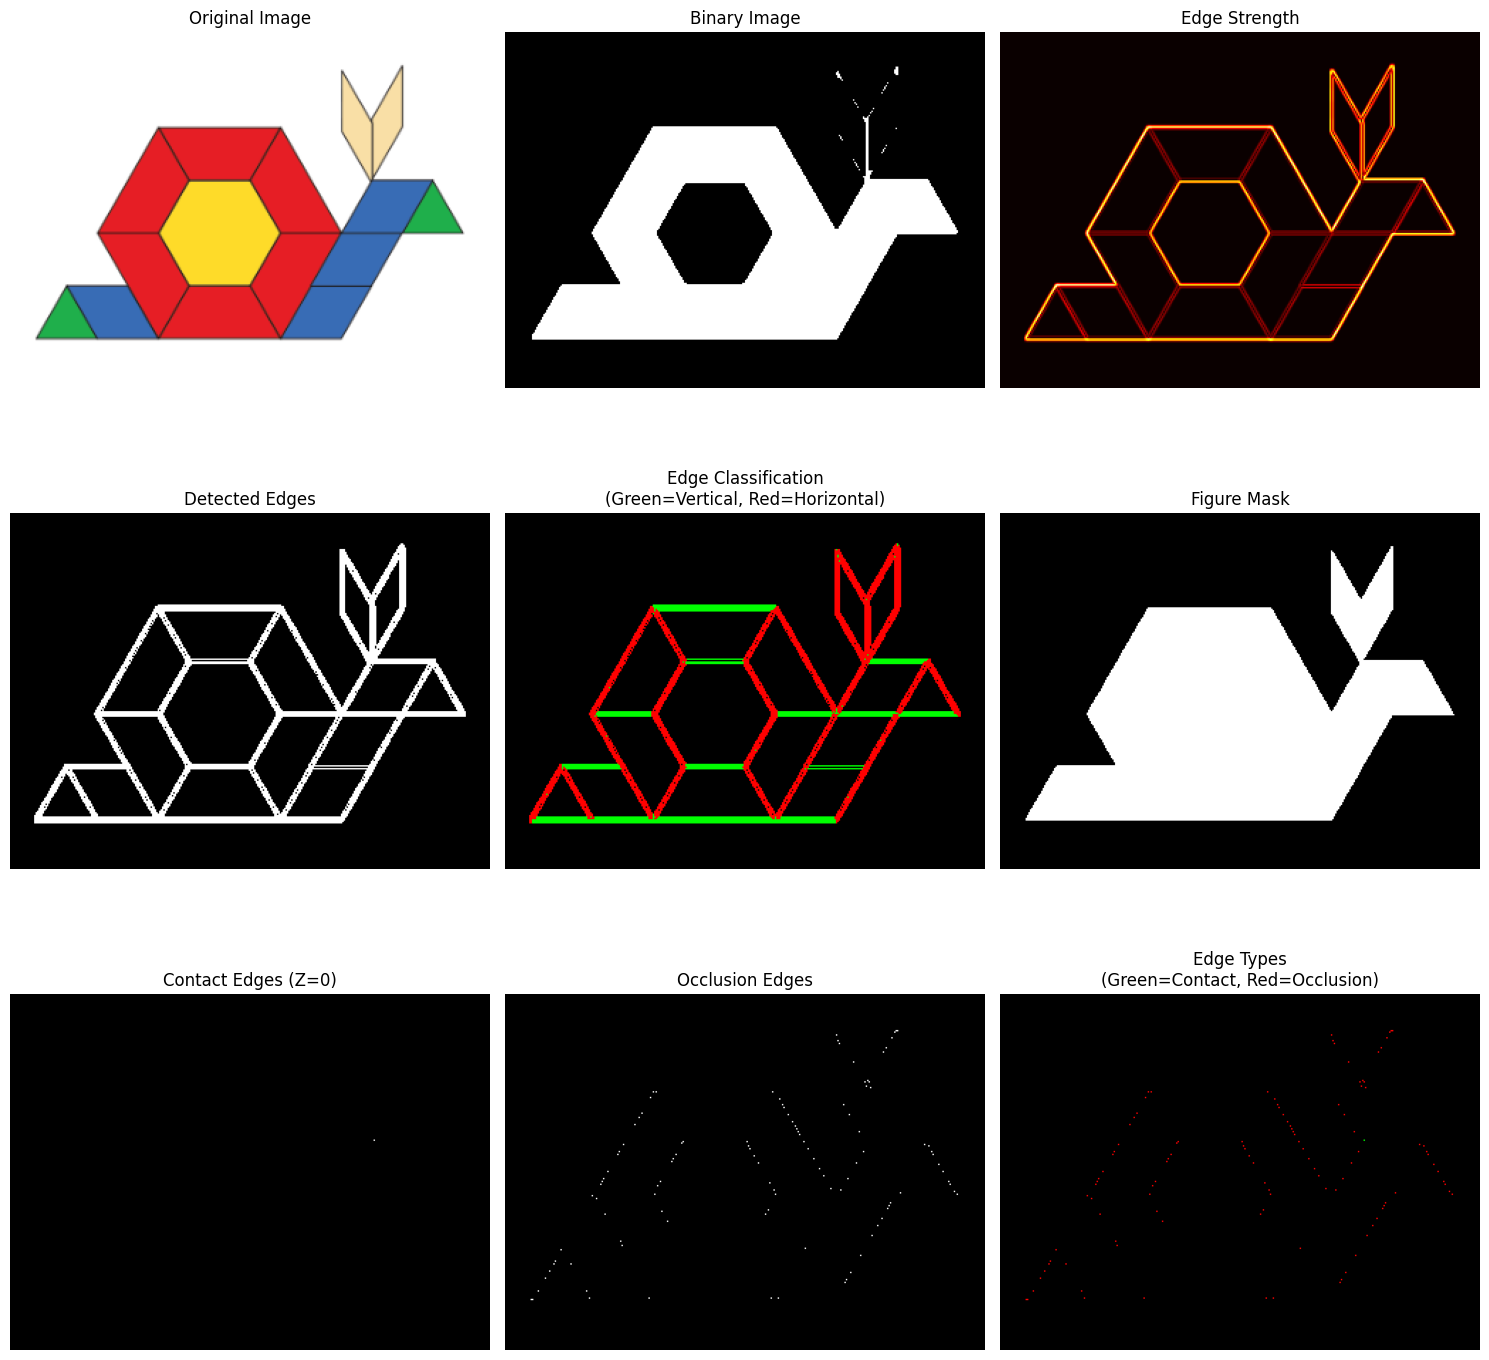

Preprocessing visualization saved to 'preprocessing_image7.png'
  Edges detected: 8160
  Vertical edges: 2782
  Horizontal edges: 5378
  Contact edges: 1
  Occlusion edges: 112

PREPROCESSING COMPLETE


In [11]:
if __name__ == "__main__":
    import os

    # Choose the image to process
    img_path = "image7.png"  

    # Check file exists
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        exit()

    # Create preprocessor
    preprocessor = ImagePreprocessor(edge_threshold=30, vertical_tolerance=15)

    print(f"\nProcessing {img_path}...")

    # Load image
    img = cv2.imread(img_path)

    # Run preprocessing
    results = preprocessor.process(img)

    # Visualize results
    preprocessor.visualize_preprocessing(
        img,
        results,
        save_path=f'preprocessing_{os.path.basename(img_path)}'
    )

    # Print stats
    print(f"  Edges detected: {np.sum(results['edges'] > 0)}")
    print(f"  Vertical edges: {np.sum(results['vertical_mask'] & (results['edges'] > 0))}")
    print(f"  Horizontal edges: {np.sum(results['horizontal_mask'] & (results['edges'] > 0))}")
    print(f"  Contact edges: {np.sum(results['contact_edges'] > 0)}")
    print(f"  Occlusion edges: {np.sum(results['occlusion_edges'] > 0)}")

    print("\nPREPROCESSING COMPLETE")